In [5]:
import os
import math
import random
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
from torchvision.models import SqueezeNet1_0_Weights
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset as TorchDataset
from PIL import Image
from sklearn.model_selection import train_test_split
from collections import Counter
from os.path import join


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
Dataset = "/content/drive/MyDrive/Dataset"

In [6]:
class CustomDataGenerator(Dataset):
    def __init__(self, x, y, label_encoder, batch_size=32, target_size=(128, 128),
                 rotation_range=20, width_shift_range=0.2, height_shift_range=0.2,
                 zoom_range=0.2, horizontal_flip=True, train=True):
        self.x = []
        self.y = []
        self.label_encoder = label_encoder
        self.batch_size = batch_size
        self.target_size = target_size
        self.rotation_range = rotation_range
        self.width_shift_range = width_shift_range
        self.height_shift_range = height_shift_range
        self.zoom_range = zoom_range
        self.horizontal_flip = horizontal_flip
        self.train = train
        self.skipped_images = 0

        # Filter out broken images during initialization
        for img_path, label in zip(x, y):
            if os.path.exists(img_path):
                try:
                    with Image.open(img_path) as img:
                        img.verify()  # Verify the image
                    self.x.append(img_path)
                    self.y.append(label)
                except Exception as e:
                    print(f"Skipping corrupted image {img_path}: {e}")
                    self.skipped_images += 1
            else:
                print(f"Image path does not exist: {img_path}")

        self.classes = set(item.split("_")[0] for item in os.listdir(os.path.dirname(self.x[0])))

        # Define data augmentation transforms
        self.transforms = transforms.Compose([
            transforms.Resize(self.target_size),
            transforms.RandomHorizontalFlip() if self.horizontal_flip else transforms.Lambda(lambda x: x),
            transforms.RandomRotation(self.rotation_range) if self.rotation_range else transforms.Lambda(lambda x: x),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        image_path = self.x[index]
        label = self.y[index]

        image = Image.open(image_path).convert('RGB')
        image = self.transforms(image)

        label_encoded = self.label_encoder.transform([label])[0]
        return image, label_encoded


In [8]:
def freeze_layers(model):
    for param in model.parameters():
        param.requires_grad = False



#weights = "/home/shima/.cache/torch/hub/checkpoints"
def create_squeezenet_model(num_classes=4, freeze=True):
    model = models.squeezenet1_0(pretrained=True)
    if freeze:
        freeze_layers(model)


    model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1, 1), stride=(1, 1))
    model.num_classes = num_classes

    # Initialize the new classifier layer
    nn.init.normal_(model.classifier[1].weight, mean=0.0, std=0.01)
    if model.classifier[1].bias is not None:
        nn.init.constant_(model.classifier[1].bias, 0)

    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss()
    return model, optimizer, criterion

def dataset_split(dataset_path: str, test_split: float = 0.2, val_split: float = 0.2):
    images_files = []
    labels = []

    for item in os.listdir(dataset_path):
        item_path = join(dataset_path, item)
        if os.path.isdir(item_path):
            class_label = item
            for image_file in os.listdir(item_path):
                image_path = join(item_path, image_file)
                images_files.append(image_path)
                labels.append(class_label)

    print(f"Total number of images: {len(images_files)}")
    print(f"Unique class labels: {set(labels)}")

    x_train, x_test, y_train, y_test = train_test_split(images_files, labels, test_size=test_split, random_state=42, stratify=labels)
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=val_split, random_state=42, stratify=y_train)

    print(f"Train samples: {len(x_train)}")
    print(f"Validation samples: {len(x_val)}")
    print(f"Test samples: {len(x_test)}")

    return x_train, y_train, x_val, y_val, x_test, y_test

if __name__ == '__main__':
    dataset_path = "/content/drive/MyDrive/Dataset"
    x_train, y_train, x_val, y_val, x_test, y_test = dataset_split(dataset_path)
    print("Original data:")
    print("train:", Counter(y_train))
    print("val:", Counter(y_val))
    print("test:", Counter(y_test))

    label_encoder = LabelEncoder()
    label_encoder.fit(y_train + y_val + y_test)

    train_dataset = CustomDataGenerator(x_train, y_train, label_encoder, train=True, batch_size=16, target_size=(128, 128))
    print(f"Skipped images in train dataset: {train_dataset.skipped_images}")

    val_dataset = CustomDataGenerator(x_val, y_val, label_encoder, train=False, batch_size=32, target_size=(128, 128))
    print(f"Skipped images in validation dataset: {val_dataset.skipped_images}")

    test_dataset = CustomDataGenerator(x_test, y_test, label_encoder, train=False, batch_size=32, target_size=(128, 128))
    print(f"Skipped images in test dataset: {test_dataset.skipped_images}")


    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    num_classes = len(label_encoder.classes_)
    model, optimizer, criterion = create_squeezenet_model(num_classes, freeze=True)

    num_epochs = 50
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        train_loss = train_loss / len(train_loader.dataset)
        train_accuracy = train_correct / len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        val_correct = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = val_correct / len(val_loader.dataset)

        print(f'Epoch {epoch+1}/{num_epochs}, '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    model.eval()
    test_correct = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            test_correct += (predicted == labels).sum().item()

    test_accuracy = test_correct / len(test_loader.dataset)
    print(f'Test Accuracy: {test_accuracy:.4f}')

Total number of images: 200
Unique class labels: {'OpenPalm', 'PeaceSign', 'ThumbsUp', 'Fist'}
Train samples: 128
Validation samples: 32
Test samples: 40
Original data:
train: Counter({'OpenPalm': 32, 'Fist': 32, 'PeaceSign': 32, 'ThumbsUp': 32})
val: Counter({'ThumbsUp': 8, 'PeaceSign': 8, 'OpenPalm': 8, 'Fist': 8})
test: Counter({'Fist': 10, 'PeaceSign': 10, 'OpenPalm': 10, 'ThumbsUp': 10})
Skipped images in train dataset: 0
Skipped images in validation dataset: 0
Skipped images in test dataset: 0


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/50, Train Loss: 1.5070, Train Acc: 0.2344, Val Loss: 1.3476, Val Acc: 0.2812
Epoch 2/50, Train Loss: 1.3215, Train Acc: 0.3203, Val Loss: 1.3658, Val Acc: 0.2500
Epoch 3/50, Train Loss: 1.1788, Train Acc: 0.5156, Val Loss: 1.2143, Val Acc: 0.5000
Epoch 4/50, Train Loss: 1.0699, Train Acc: 0.6250, Val Loss: 1.1571, Val Acc: 0.5938
Epoch 5/50, Train Loss: 0.8969, Train Acc: 0.6719, Val Loss: 1.0443, Val Acc: 0.5625
Epoch 6/50, Train Loss: 0.7957, Train Acc: 0.7500, Val Loss: 1.0045, Val Acc: 0.6562
Epoch 7/50, Train Loss: 0.7014, Train Acc: 0.7734, Val Loss: 0.8131, Val Acc: 0.7188
Epoch 8/50, Train Loss: 0.5719, Train Acc: 0.8281, Val Loss: 0.7767, Val Acc: 0.7500
Epoch 9/50, Train Loss: 0.5010, Train Acc: 0.8594, Val Loss: 0.7425, Val Acc: 0.7188
Epoch 10/50, Train Loss: 0.4881, Train Acc: 0.8828, Val Loss: 0.8181, Val Acc: 0.7500
Epoch 11/50, Train Loss: 0.4915, Train Acc: 0.8672, Val Loss: 0.8065, Val Acc: 0.6875
Epoch 12/50, Train Loss: 0.4155, Train Acc: 0.8828, Val Loss: 0

In [9]:
import matplotlib.pyplot as plt
import math

def show_all_test_samples(model, test_loader, label_encoder):
    model.eval()
    device = next(model.parameters()).device

    all_images = []
    all_labels = []
    all_predictions = []

    # Iterate through all test data
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_images.extend(images.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    num_images = len(all_images)
    num_cols = 5  # You can adjust this to change the number of columns in the plot
    num_rows = math.ceil(num_images / num_cols)

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 4 * num_rows))
    axes = axes.flatten()

    for i in range(num_images):
        ax = axes[i]
        img = np.transpose(all_images[i], (1, 2, 0))
        img = (img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406]).clip(0, 1)

        ax.imshow(img)
        true_label = label_encoder.inverse_transform([all_labels[i]])[0]
        pred_label = label_encoder.inverse_transform([all_predictions[i]])[0]

        ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=8)
        ax.axis('off')

    # Remove any unused subplots
    for i in range(num_images, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()



In [11]:
show_all_test_samples(model, test_loader, label_encoder)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def analyze_misclassifications(model, test_loader, label_encoder):
    model.eval()
    device = next(model.parameters()).device

    all_labels = []
    all_predictions = []

    # Collect all predictions and true labels
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Normalize confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Get class names
    class_names = label_encoder.classes_

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Normalized Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Analyze misclassifications
    misclassification_rates = 1 - np.diag(cm_normalized)
    sorted_misclassifications = sorted(zip(class_names, misclassification_rates), key=lambda x: x[1], reverse=True)

    print("Classes most often misclassified:")
    for class_name, rate in sorted_misclassifications:
        print(f"{class_name}: {rate:.2%}")

    # Analyze which classes are confused with each other
    print("\nMost common misclassifications:")
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            if i != j and cm[i, j] > 0:
                print(f"{class_names[i]} misclassified as {class_names[j]}: {cm[i, j]} times ({cm_normalized[i, j]:.2%})")


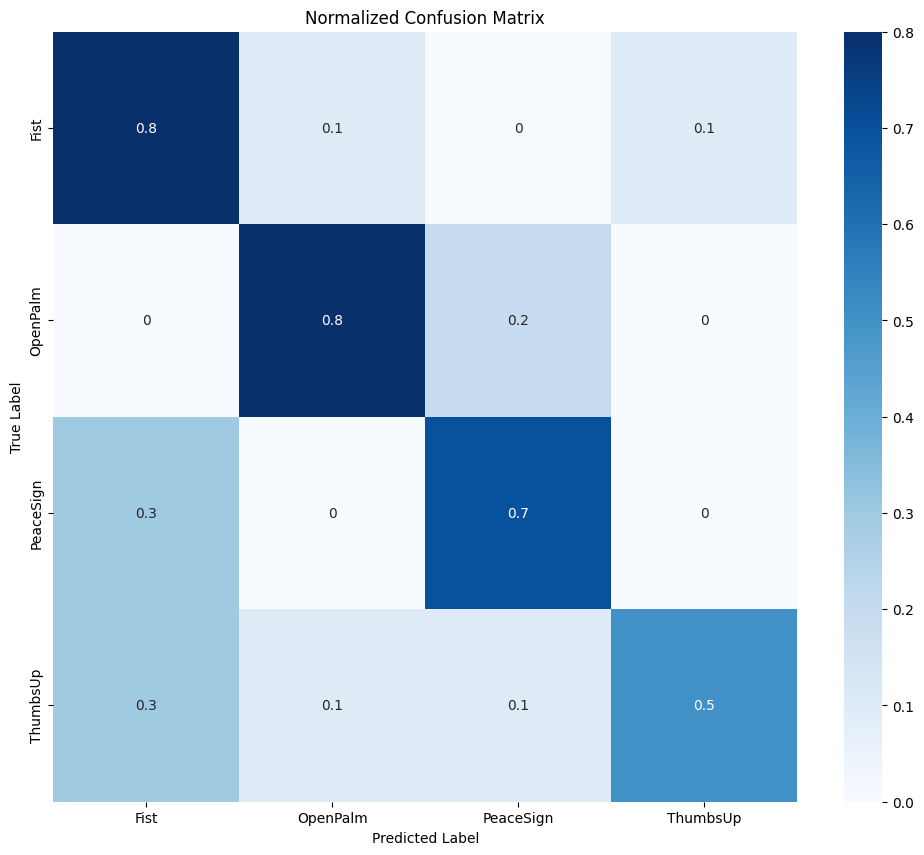

Classes most often misclassified:
ThumbsUp: 50.00%
PeaceSign: 30.00%
Fist: 20.00%
OpenPalm: 20.00%

Most common misclassifications:
Fist misclassified as OpenPalm: 1 times (10.00%)
Fist misclassified as ThumbsUp: 1 times (10.00%)
OpenPalm misclassified as PeaceSign: 2 times (20.00%)
PeaceSign misclassified as Fist: 3 times (30.00%)
ThumbsUp misclassified as Fist: 3 times (30.00%)
ThumbsUp misclassified as OpenPalm: 1 times (10.00%)
ThumbsUp misclassified as PeaceSign: 1 times (10.00%)


In [13]:
analyze_misclassifications(model, test_loader, label_encoder)
